# Safe Skin: Vision Transformer (ViT) for Skin Cancer Classification on HAM10000

In [1]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")

CUDA available: True
GPU: Tesla T4


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/skin-cancer-mnist-ham10000


## 1. Import Libraries

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
from huggingface_hub import hf_hub_download
from transformers import ViTForImageClassification, ViTFeatureExtractor
import requests
import zipfile
import io
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [13]:
image_dirs = ['/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1','/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2']

In [14]:
# Load metadata
metadata = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')

In [15]:
classes = ['bkl', 'bcc', 'akiec', 'vasc', 'nv', 'mel', 'df']
class_names = {
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'df': 'Dermatofibroma'
}
num_classes = len(classes)

In [16]:
num_classes

7

In [17]:
print("Dataset Info:")
print(metadata.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB
None


In [18]:
print("\nClass Distribution:")
print(metadata['dx'].value_counts())


Class Distribution:
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


In [19]:
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [20]:
metadata.tail()

,lesion_id,image_id,dx,dx_type,age,sex,localization
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face
10014,HAM_0003521,ISIC_0032258,mel,histo,70.0,female,back


In [21]:
metadata.describe()

,age
count,9958.000000
mean,51.863828
std,16.968614
min,0.000000
25%,40.000000
50%,50.000000
75%,65.000000
max,85.000000


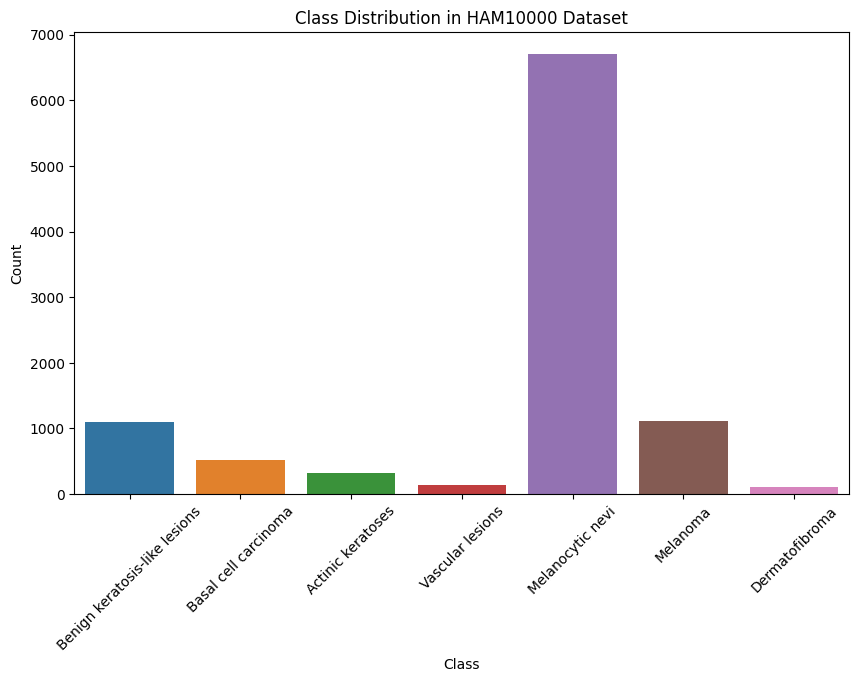

In [22]:
plt.figure(figsize=(10, 6))
sns.countplot(x='dx', data=metadata, order=classes)
plt.title('Class Distribution in HAM10000 Dataset')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(ticks=range(len(classes)), labels=[class_names[c] for c in classes], rotation=45)
plt.show()

In [23]:
def find_image_path(image_id):
    for dir_path in image_dirs:
        img_path = os.path.join(dir_path, f"{image_id}.jpg")
        if os.path.exists(img_path):
            return img_path
    return None

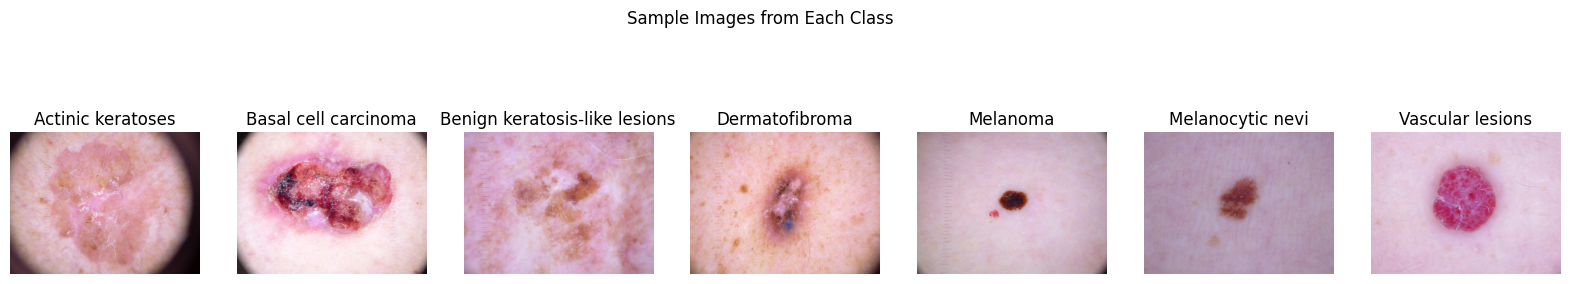

In [24]:
sample_images = metadata.groupby('dx').first().reset_index()
fig, axes = plt.subplots(1, num_classes, figsize=(20, 4))
for i, row in sample_images.iterrows():
    img_path = find_image_path(row['image_id'])
    if img_path:
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(class_names[row['dx']])
        axes[i].axis('off')
    else:
        axes[i].set_title(f"{class_names[row['dx']]} (Not Found)")
        axes[i].axis('off')
plt.suptitle('Sample Images from Each Class')
plt.show()

## Data Preprocessing

In [25]:
print("\nMissing Values:")
print(metadata.isnull().sum())
metadata['age'].fillna(metadata['age'].mean(), inplace=True)


Missing Values:
lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64


In [26]:
metadata['sex'].fillna('unknown', inplace=True)

In [27]:
metadata['age'] = metadata['age'].clip(lower=0, upper=100)

In [28]:
class SkinCancerDataset(Dataset):
    def __init__(self, metadata, image_dirs, transform=None):
        self.metadata = metadata
        self.image_dirs = image_dirs
        self.transform = transform
        self.label_map = {c: i for i, c in enumerate(classes)}
    
    def __len__(self):
        return len(self.metadata)
    
    def __getitem__(self, idx):
        image_id = self.metadata.iloc[idx]['image_id']
        img_path = None
        for dir_path in self.image_dirs:
            potential_path = os.path.join(dir_path, f"{image_id}.jpg")
            if os.path.exists(potential_path):
                img_path = potential_path
                break
        if img_path is None:
            raise FileNotFoundError(f"Image {image_id}.jpg not found in {self.image_dirs}")
        image = Image.open(img_path).convert('RGB')
        label = self.label_map[self.metadata.iloc[idx]['dx']]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [29]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [30]:
# Split dataset
train_df, val_df = train_test_split(metadata, test_size=0.2, stratify=metadata['dx'], random_state=42)
train_dataset = SkinCancerDataset(train_df, image_dirs, transform=transform)
val_dataset = SkinCancerDataset(val_df, image_dirs, transform=transform)


In [31]:
# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Training samples: 8012
Validation samples: 2003


## 5. Model Architecture: Vision Transformer

In [32]:
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=num_classes,
    ignore_mismatched_sizes=True
)


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
# Modify classification head
model.classifier = nn.Linear(model.config.hidden_size, num_classes)

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

## 6. Model Training

In [34]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0
        
        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        train_loss /= train_total
        train_acc = train_correct / train_total
        
        # Validation loop
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        all_preds, all_labels = [], []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images).logits
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        val_loss /= val_total
        val_acc = val_correct / val_total
        
        # Store metrics
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")
    
    return history, all_preds, all_labels


In [28]:
# Train the model
history, all_preds, all_labels = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=4)

Epoch 1/10, Train Loss: 0.7200, Train Accuracy: 0.7516, Val Loss: 0.5969, Val Accuracy: 0.8028
Epoch 2/10, Train Loss: 0.4211, Train Accuracy: 0.8576, Val Loss: 0.4533, Val Accuracy: 0.8402
Epoch 3/10, Train Loss: 0.2386, Train Accuracy: 0.9231, Val Loss: 0.4381, Val Accuracy: 0.8502
Epoch 4/10, Train Loss: 0.1197, Train Accuracy: 0.9629, Val Loss: 0.4797, Val Accuracy: 0.8577
Epoch 5/10, Train Loss: 0.0813, Train Accuracy: 0.9757, Val Loss: 0.4555, Val Accuracy: 0.8627
Epoch 6/10, Train Loss: 0.0530, Train Accuracy: 0.9844, Val Loss: 0.5451, Val Accuracy: 0.8517
Epoch 7/10, Train Loss: 0.0551, Train Accuracy: 0.9825, Val Loss: 0.5504, Val Accuracy: 0.8622
Epoch 8/10, Train Loss: 0.0433, Train Accuracy: 0.9874, Val Loss: 0.6361, Val Accuracy: 0.8497
Epoch 9/10, Train Loss: 0.0452, Train Accuracy: 0.9866, Val Loss: 0.6336, Val Accuracy: 0.8397
Epoch 10/10, Train Loss: 0.0476, Train Accuracy: 0.9866, Val Loss: 0.5156, Val Accuracy: 0.8697


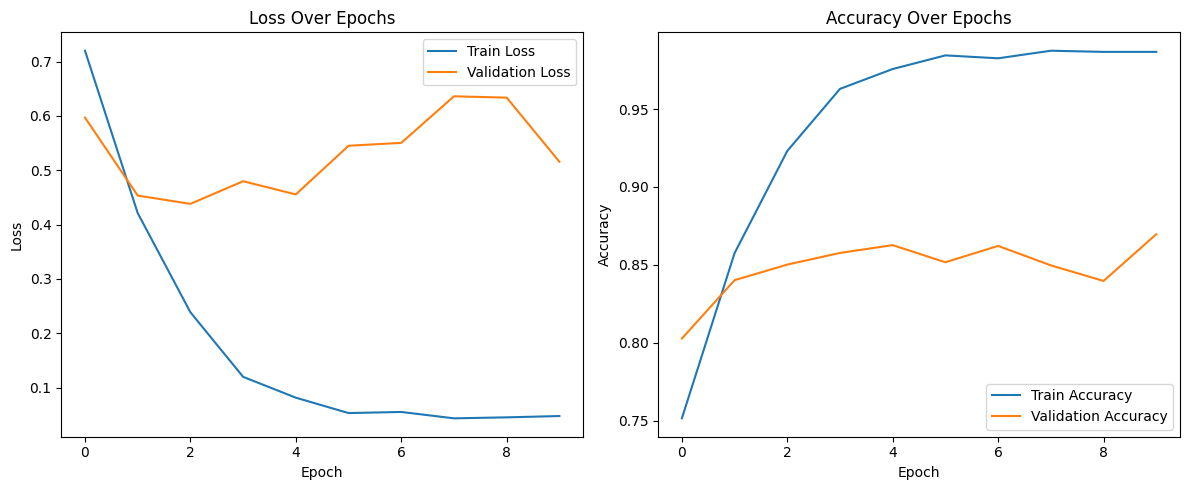

In [29]:

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


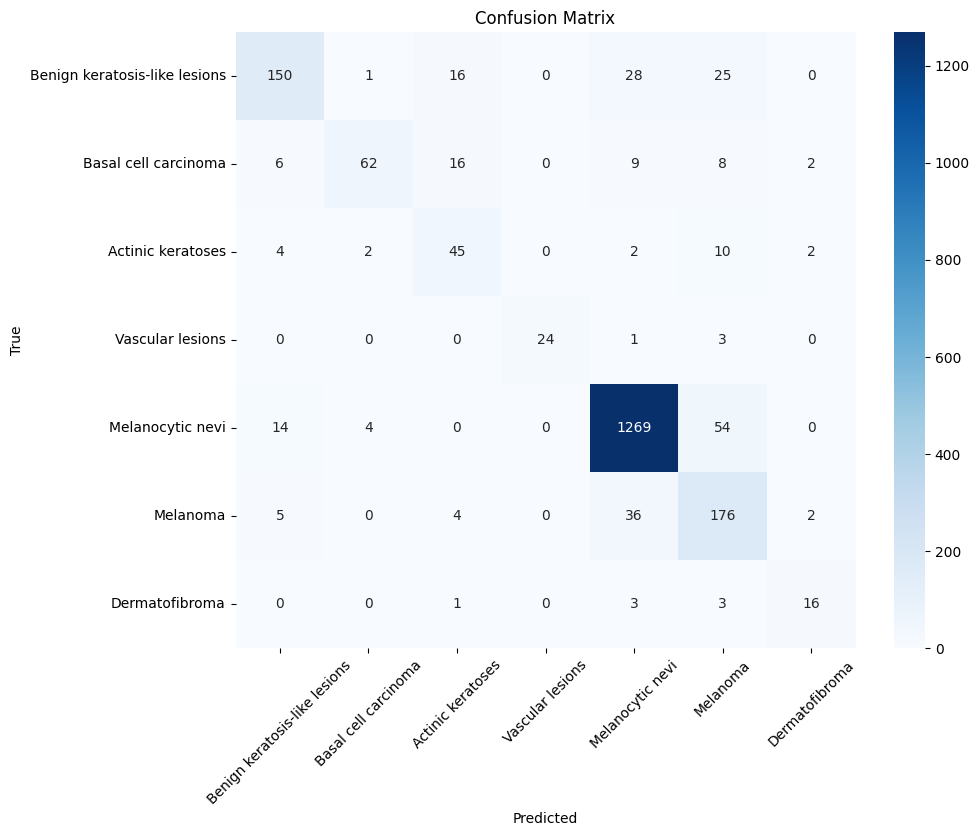

In [30]:

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[class_names[c] for c in classes], yticklabels=[class_names[c] for c in classes])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


In [31]:

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=[class_names[c] for c in classes]))



Classification Report:
                               precision    recall  f1-score   support

Benign keratosis-like lesions       0.84      0.68      0.75       220
         Basal cell carcinoma       0.90      0.60      0.72       103
            Actinic keratoses       0.55      0.69      0.61        65
             Vascular lesions       1.00      0.86      0.92        28
             Melanocytic nevi       0.94      0.95      0.94      1341
                     Melanoma       0.63      0.79      0.70       223
               Dermatofibroma       0.73      0.70      0.71        23

                     accuracy                           0.87      2003
                    macro avg       0.80      0.75      0.77      2003
                 weighted avg       0.88      0.87      0.87      2003



### we can see that the model works well when trained with 4 epochs

In [35]:
history, all_preds, all_labels = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=4)

Epoch 1/4, Train Loss: 0.7306, Train Accuracy: 0.7546, Val Loss: 0.5299, Val Accuracy: 0.8158
Epoch 2/4, Train Loss: 0.4077, Train Accuracy: 0.8678, Val Loss: 0.4385, Val Accuracy: 0.8517
Epoch 3/4, Train Loss: 0.2351, Train Accuracy: 0.9214, Val Loss: 0.3749, Val Accuracy: 0.8692
Epoch 4/4, Train Loss: 0.1221, Train Accuracy: 0.9612, Val Loss: 0.4395, Val Accuracy: 0.8642


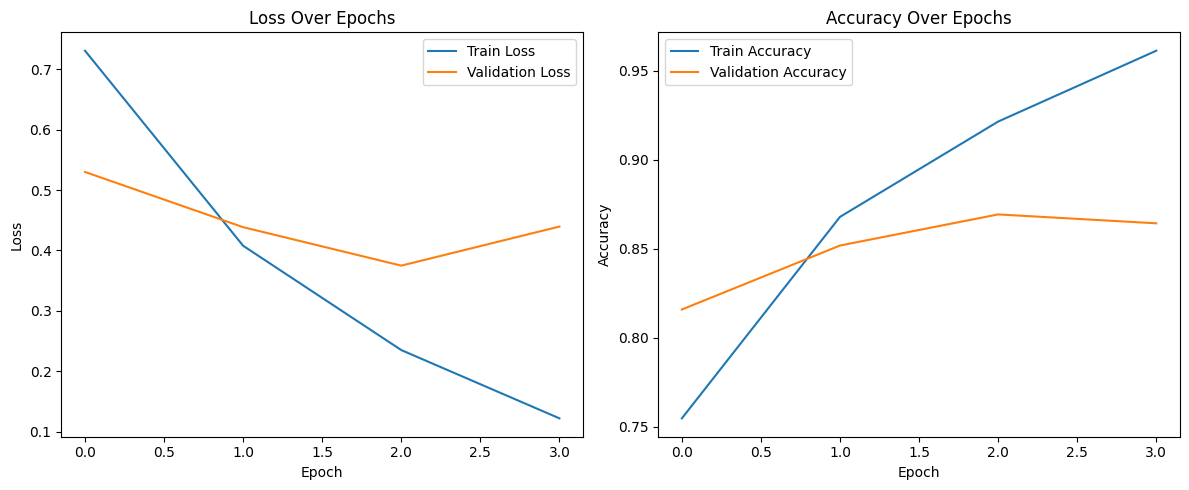

In [36]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

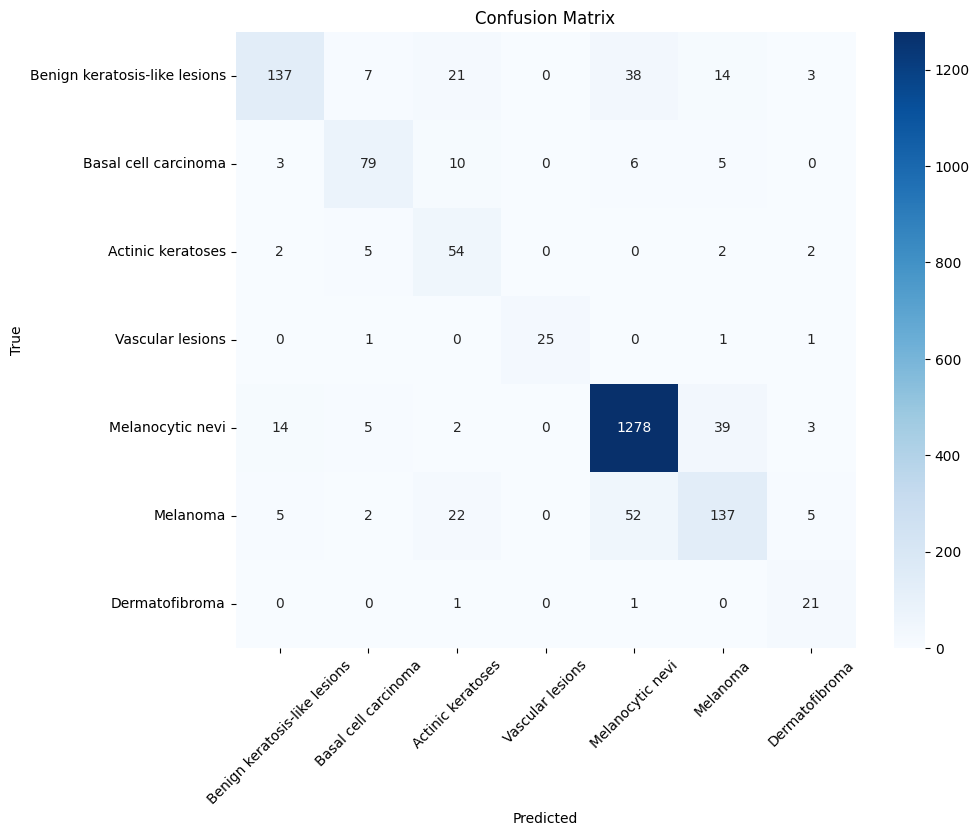

In [37]:
# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[class_names[c] for c in classes], yticklabels=[class_names[c] for c in classes])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [38]:
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=[class_names[c] for c in classes]))


Classification Report:
                               precision    recall  f1-score   support

Benign keratosis-like lesions       0.85      0.62      0.72       220
         Basal cell carcinoma       0.80      0.77      0.78       103
            Actinic keratoses       0.49      0.83      0.62        65
             Vascular lesions       1.00      0.89      0.94        28
             Melanocytic nevi       0.93      0.95      0.94      1341
                     Melanoma       0.69      0.61      0.65       223
               Dermatofibroma       0.60      0.91      0.72        23

                     accuracy                           0.86      2003
                    macro avg       0.77      0.80      0.77      2003
                 weighted avg       0.87      0.86      0.86      2003



In [39]:
import os
from transformers import ViTForImageClassification, ViTFeatureExtractor


model_save_path = "/kaggle/working/vit_skin_cancer_model"
os.makedirs(model_save_path, exist_ok=True)

# Lưu mô hình
model.save_pretrained(model_save_path)


feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
feature_extractor.save_pretrained(model_save_path)

print(f"model ss saved at: {model_save_path}")

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

model ss saved at: /kaggle/working/vit_skin_cancer_model


In [41]:
import torch
from PIL import Image
from transformers import ViTForImageClassification, ViTImageProcessor

# --- 1. Định nghĩa đường dẫn đến mô hình đã train ---

model_directory = '/kaggle/working/vit_skin_cancer_model'

# --- 2. Tải lại bộ xử lý hình ảnh (ImageProcessor) và mô hình ---
processor = ViTImageProcessor.from_pretrained(model_directory)
model = ViTForImageClassification.from_pretrained(model_directory)

# --- 3. Đặt mô hình ở chế độ đánh giá (inference mode) ---
model.eval()

# --- 4. Chuyển mô hình sang GPU nếu có thể ---
if torch.cuda.is_available():
    model.to('cuda')
    print("Mô hình đã được chuyển sang GPU.")
else:
    print("Không tìm thấy GPU, mô hình sẽ chạy trên CPU.")


# --- 5. Lấy ánh xạ id2label từ cấu hình mô hình ---
# Trainer tự động lưu id2label vào config.json của mô hình
id2label = model.config.id2label
print(f"Các nhãn được mô hình dự đoán: {id2label}")

# --- 6. Hàm để dự đoán một ảnh mới ---
def predict_single_image(image_path):
    # Mở ảnh và chuyển sang định dạng RGB
    image = Image.open(image_path).convert("RGB")

    # Tiền xử lý ảnh: resize, normalize, chuyển sang tensor và thêm batch dimension
    # Processor tự động làm tất cả những việc này
    inputs = processor(images=image, return_tensors="pt")

    # Di chuyển đầu vào lên GPU nếu mô hình đang ở GPU
    if torch.cuda.is_available():
        inputs = {k: v.to('cuda') for k, v in inputs.items()}

    # Thực hiện dự đoán (không tính gradient để tiết kiệm bộ nhớ và tăng tốc)
    with torch.no_grad():
        outputs = model(**inputs)

    # Lấy logits và chuyển đổi sang xác suất
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1)

    # Lấy xác suất cao nhất và chỉ số lớp
    predicted_probability = torch.max(probabilities).item()
    predicted_class_idx = torch.argmax(logits, dim=1).item()

    # Ánh xạ chỉ số lớp thành nhãn thực tế
    predicted_label = id2label[predicted_class_idx]

    return predicted_label, predicted_probability

# --- Ví dụ sử dụng để dự đoán một ảnh ---
# Thay thế 'path/to/your/new_image.jpg' bằng đường dẫn thực tế của ảnh bạn muốn dự đoán
test_image_path = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0024306.jpg' # Ví dụ: 'data/test/melanoma/ISIC_0024317.jpg'

try:
    predicted_label, confidence = predict_single_image(test_image_path)
    print(f"\nẢnh: {test_image_path}")
    print(f"Dự đoán: {predicted_label}")
    print(f"Độ tự tin: {confidence:.4f}")
except FileNotFoundError:
    print(f"Lỗi: Không tìm thấy tệp ảnh tại đường dẫn '{test_image_path}'. Vui lòng kiểm tra lại đường dẫn.")
except Exception as e:
    print(f"Đã xảy ra lỗi khi dự đoán: {e}")

Mô hình đã được chuyển sang GPU.
Các nhãn được mô hình dự đoán: {0: 'LABEL_0', 1: 'LABEL_1', 2: 'LABEL_2', 3: 'LABEL_3', 4: 'LABEL_4', 5: 'LABEL_5', 6: 'LABEL_6'}

Ảnh: /kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0024306.jpg
Dự đoán: LABEL_4
Độ tự tin: 0.9963


In [42]:
import os
from IPython.display import FileLink


os.system("zip -r vit_skin_cancer_model.zip /kaggle/working/vit_skin_cancer_model")


FileLink('vit_skin_cancer_model.zip')

  adding: kaggle/working/vit_skin_cancer_model/ (stored 0%)
  adding: kaggle/working/vit_skin_cancer_model/config.json (deflated 54%)
  adding: kaggle/working/vit_skin_cancer_model/model.safetensors (deflated 7%)
  adding: kaggle/working/vit_skin_cancer_model/preprocessor_config.json (deflated 46%)


/kaggle/working/vit_skin_cancer_model.zip